<a href="https://colab.research.google.com/github/BuddhikaRoshan/HemoAi/blob/Heshani/predictioncode1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading model...
Analyzing image...
----------------------------------------
Result     : thalassemia
Confidence : 57.58%
----------------------------------------


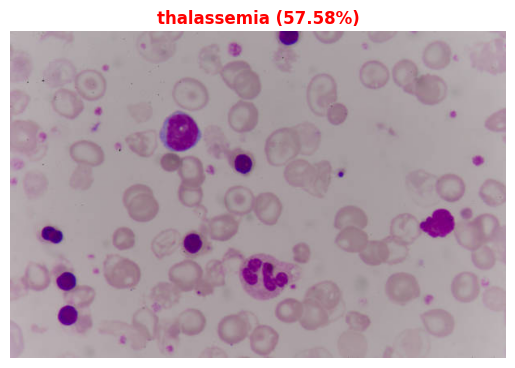

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

# ========================
# CONFIG (matches training)
# ========================
IMG_SIZE = 128
MODEL_PATH = "/content/drive/MyDrive/new/cnn_vit_rbc_manualsplit.keras"
SCALER_PATH = "/content/drive/MyDrive/new/scaler (1).pkl"
ENCODER_PATH = "/content/drive/MyDrive/new/label_encoder (1).pkl"
MAX_RBC_PER_IMAGE = 25

# ========================
# FEATURE FUNCTIONS
# ========================
def target_cell_score(gray):
    h, w = gray.shape
    cx, cy = w//2, h//2
    Y, X = np.ogrid[:h, :w]
    d = np.sqrt((X - cx)**2 + (Y - cy)**2)
    r = np.max(d)
    c = gray[d < r*0.25]
    m = gray[(d >= r*0.25) & (d < r*0.5)]
    o = gray[(d >= r*0.5) & (d < r*0.75)]
    if len(c)==0 or len(m)==0 or len(o)==0:
        return 0
    return (np.mean(m)-np.mean(c)) + (np.mean(m)-np.mean(o))

def blue_ratio(rbc):
    b, g, r = cv2.split(rbc)
    return np.mean(b)/(np.mean(r)+1e-5)

def compute_rbc_features(rbc):
    gray = cv2.cvtColor(rbc, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    return [
        target_cell_score(gray),
        blue_ratio(rbc),
        abs(h-w)/max(h,w),
        h*w
    ]

# ========================
# RBC EXTRACTION
# ========================
def extract_rbcs(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, th = cv2.threshold(
        blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )
    contours, _ = cv2.findContours(
        th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    cells, feats = [], []

    for c in contours[:MAX_RBC_PER_IMAGE]:
        if cv2.contourArea(c) < 100:
            continue
        x, y, w, h = cv2.boundingRect(c)
        rbc = image[y:y+h, x:x+w]
        rbc = cv2.resize(rbc, (IMG_SIZE, IMG_SIZE))
        cells.append(rbc)
        feats.append(compute_rbc_features(rbc))

    return np.array(cells), np.array(feats)

# ========================
# PREDICTION FUNCTION
# ========================
def predict_image(image_path):

    if not os.path.exists(image_path):
        print("❌ Image not found")
        return

    print("Loading model...")
    model = tf.keras.models.load_model(MODEL_PATH)
    scaler = pickle.load(open(SCALER_PATH, "rb"))
    encoder = pickle.load(open(ENCODER_PATH, "rb"))

    image = cv2.imread(image_path)
    rbcs, feats = extract_rbcs(image)

    if len(rbcs) == 0:
        print("❌ No RBCs detected")
        return

    # Preprocess
    rbcs = rbcs / 255.0
    feats = scaler.transform(feats)

    print("Analyzing image...")
    preds = model.predict([rbcs, feats], verbose=0)

    mean_pred = np.mean(preds, axis=0)
    class_id = np.argmax(mean_pred)
    label = encoder.inverse_transform([class_id])[0]
    confidence = np.max(mean_pred) * 100

    print("-" * 40)
    print(f"Result     : {label}")
    print(f"Confidence : {confidence:.2f}%")
    print("-" * 40)

    # Visualization
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"{label} ({confidence:.2f}%)",
              color="red" if label != "healthy" else "green",
              fontweight="bold")
    plt.axis("off")
    plt.show()

# ========================
# RUN (like your friend's)
# ========================
if __name__ == "__main__":
    test_image_path = "/content/drive/MyDrive/new/images/thalassemia_web.jpg"
    predict_image(test_image_path)


Loading model...
Analyzing image...
----------------------------------------
Result     : healthy
Confidence : 56.26%
----------------------------------------


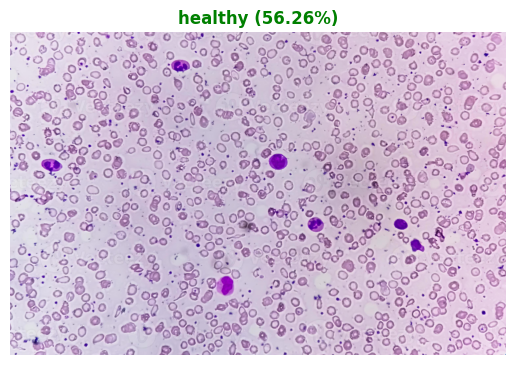

In [ ]:
if __name__ == "__main__":
    test_image_path = "/content/drive/MyDrive/new/images/heal_an.jpg"
    predict_image(test_image_path)

Loading model...
Analyzing image...
----------------------------------------
Result     : healthy
Confidence : 97.65%
----------------------------------------


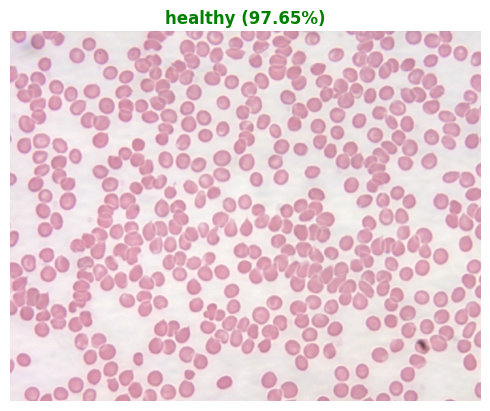

In [6]:
if __name__ == "__main__":
    test_image_path = "/content/drive/MyDrive/new/images/healthy_web .jpg"
    predict_image(test_image_path)